# Sweet Lift Taxi Ride Forecasting

# Introduction

The goal for this project is to predict the number of rides that the taxi company Sweet Lift Taxi will give during peak hours. Data is given  from historical data, and the next hour needs to be predicted. I will use the dataset resampled to every one hour, analyze the data, and train a few different models using root mean square error as my metric. I will split the dataset into a training, validation, and test set (split chronologically rather than randomly), using the validation set to find the best hyperparameters before training a new model on the training + validation sets and ultimately testing performance on the test set and making a formal prediction for the hour following the end of the dataset. A RMSE of <48 is acceptable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse

import catboost as cb

# Load and explore data

The data comes in the form of two columns, date/time and number of orders. Date/time can be made into the index, and changed into pandas datetime64 format.

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

Make sure the datetime values are in chronological order.

In [3]:
df.sort_index(inplace=True)

There are no missing values in the orders column.

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


I want the data to be condensed into the sum of taxi rides per hour rather than the sum of taxi rides per every ten minutes, as it is now.

In [7]:
df = df.resample('1H').sum()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Looking at the length of the dataframe before and after resampling, we definitely have fewer values to work with. The data ranges from March 1st, 2018 to August 31st, 2018. I want to look at the general trend throughout this timeframe, which I can do through a statsmodel package. Using Fourier transfroms via the same statsmodel package, I will check seasonality for the last few days before the end of the dataset, to see if there is any pattern in the days leading up to the time of prediction.

In [9]:
decomposed = seasonal_decompose(df)

Text(0.5, 1.0, 'Rides given over time')

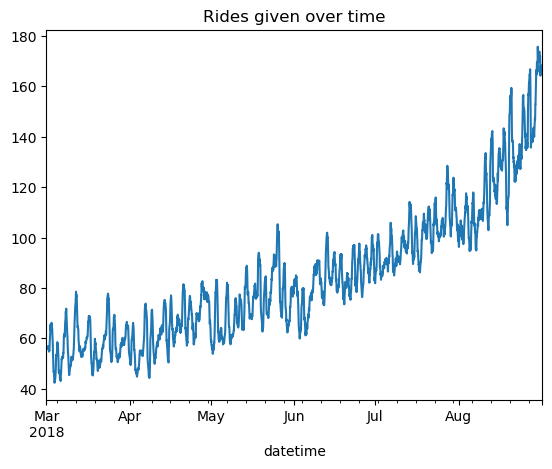

In [10]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Rides given over time')

Taxi rides were lowest in March and gradually increase as time proceeds. In March 2018, between 40 and 80 rides per hour were given, whereas in August 2018, between approximately 100 and 180 rides were given per hour.

Text(0.5, 1.0, 'Seasonality of rides in late August (Fourier transform)')

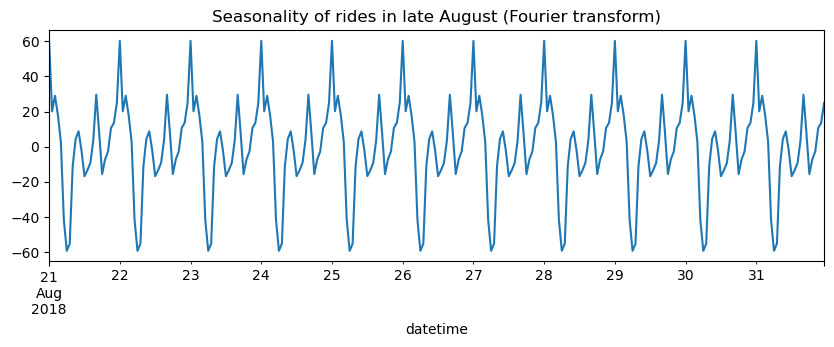

In [11]:
decomposed.seasonal['2018-08-21':'2018-08-31'].plot(figsize=(10,3))
plt.title('Seasonality of rides in late August (Fourier transform)')

This plot of seasonality shows patterns in the days leading up to the final hour in the dataset. When I start creating features, I will need to keep this in mind. Taxi rides seem to be at a maximum at midnight and at a minimum a few hours thereafter. We need to later predict the number of rides in the next hour, and this seasonality plot indicates to me that this number will be higher than the preceeding value rather than lower.

I looked into a trigonometric alternative to linear regression due to its 24-hour cycle, but I did not find a readily available option. At the very least, a polynomial regressor should be better than a linear regressor, because the trend seems to have a bit of a curve to it.

Text(0.5, 1.0, 'Residual noise from trends and seasonality')

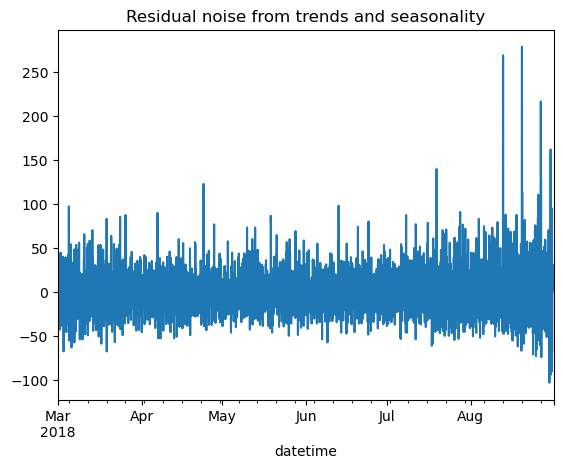

In [14]:
decomposed.resid.plot()
plt.title('Residual noise from trends and seasonality')

The residuals are not high across the board, but August has a few high residuals.

Visually, the trend seems to be increasing rides over time, but let's plot the rolling mean and standard deviation to get a better look.

<AxesSubplot:xlabel='datetime'>

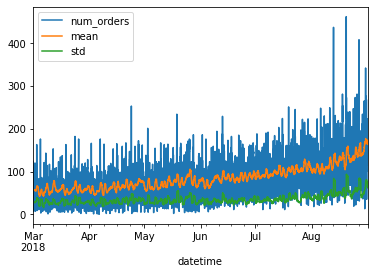

In [12]:
df_plot = df.copy()
df_plot['mean'] = df_plot['num_orders'].rolling(24).mean()
df_plot['std'] = df_plot['num_orders'].rolling(24).std()
df_plot.plot()

The upward trends over time, in terms of both mean and standard deviation, from the plot above indicates that this time series is a nonstationary stochastic process. 

## Feature engineering

We will add some columns where the data is lagged by some number of hours. Information about the date/time and day of week would also be helpful, because this information is contained only in the index and the model can use these features to utilize seasonality for its predictions. A feature with the rolling mean from the past several hours would also help the model to identify the trend.

In [13]:
def lag(df, max_lag):  
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)    
        
def rolling_mean(df, mean_size):
    df['rolling_mean'] = df['num_orders'].shift().rolling(mean_size).mean()

In [14]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

I am choosing a max lag of 6 hours because a quarter of a day feels reasonable for predicting the current rides. I am choosing a rolling mean of 4 because the number of rides seems to change quickly and I do not want the model to see too far into the past.

In [15]:
lag(df, max_lag=6)
rolling_mean(df, mean_size=4)

In [16]:
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,86.5


The table looks as it should. The nan values in the first few rows mean that these rows should be dropped. Let's do this before we split the table into several different sets.

In [17]:
df.dropna(inplace=True)

# Build predictive models

I will try out a linear regression model as a sanity check, and try a polynomial regressor as well. Beyond that I will try out a random forest model via sklearn and a CatBoost regressor, as I have read a lot of positive things about it and only minimally explored its use in my last project.

I will split the dataset into a training, validation, and test set (split chronologically rather than randomly), using the validation set to find the best hyperparameters before training a new model on the training + validation sets. I will pick the best model in terms of RMSE and test performance on the test set. I will train a model on all of the data and make a formal prediction for the hour following the end of the dataset.

In [18]:
target = df.num_orders
features = df.drop('num_orders', axis=1)

In [19]:
# We are careful to place the sets in chronological order (train -> validation -> test)
# Training + validation sets are created for later use
features_tv, features_test, target_tv, target_test = train_test_split(
    features, target, test_size=1/10, shuffle=False)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_tv, target_tv, test_size=1/9, shuffle=False)

## Linear regression

In [20]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print('RMSE for training set:', np.sqrt(mse(target_train, pred_train)))
print('RMSE for validation set:', np.sqrt(mse(target_valid, pred_valid)))

RMSE for training set: 28.979309831490838
RMSE for validation set: 40.682839398363036
CPU times: user 17.7 ms, sys: 51.2 ms, total: 68.9 ms
Wall time: 72.9 ms


Wow, I did not expect linear regression to already have performed well within our requirement of 48 with RMSE. RMSE for the validation set is 40.7, which is about 35% higher than the RMSE for the training set. The model has overfitted, but it is not outrageous.

## Polynomial regression

In [21]:
for degree in range(1, 5):
    polynomial_trans = PolynomialFeatures(degree=degree)
    features_train_poly = polynomial_trans.fit_transform(features_train)
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(features_train_poly, target_train)
    
    pred_train = poly_reg_model.predict(features_train_poly)
    pred_valid = poly_reg_model.predict(polynomial_trans.fit_transform(features_valid))
    
    print('Degree:', degree)
    print('RMSE for training set:', np.sqrt(mse(target_train, pred_train)))
    print('RMSE for validation set:', np.sqrt(mse(target_valid, pred_valid)))

Degree: 1
RMSE for training set: 28.979309831490838
RMSE for validation set: 40.682839398363036
Degree: 2
RMSE for training set: 25.376287853396484
RMSE for validation set: 39.31335171728364
Degree: 3
RMSE for training set: 21.897243004816268
RMSE for validation set: 52.01150845474393
Degree: 4
RMSE for training set: 17.62340612826726
RMSE for validation set: 146.78943649255322


I originally had tried degrees from 0 to 10 - my computer made calculations for degrees 0-4 almost instantly, and then it started making sounds I've never heard before while it tried to calculate degree 5 and up. I have reduced this range to prevent that. The linear regression model with quadratic preprocessing (degree=2) does perform slightly better than the regular linear regression with 1 degree. The gap between the RMSE for the training set and the validation set is slightly higher, so it may be more overfitted than the previous model, and this data requires a transform of features before every training and prediction, though it seems to be nearly as quick as linear regression. I suppose I will opt for this model over the standard linear regression model based on its lower RMSE and minimal additional costs.

## Random forest regressor

In [22]:
best_est = 0
best_depth = 0
best_model = None
best_rmse = 1e10
current_rmse_train = 0
best_split = 0
best_leaf = 0
for est in [5,9,10,11,15]:
    for depth in range(16,20):
        for samp_split in [2,5,10]:
            for samp_leaf in [1,5,10]:
                model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0, max_features='sqrt',
                                             min_samples_split=samp_split, min_samples_leaf=samp_leaf)
                model.fit(features_train, target_train)

                pred_valid = model.predict(features_valid)
                rmse_valid = np.sqrt(mse(target_valid, pred_valid))

                pred_train = model.predict(features_train)
                rmse_train = np.sqrt(mse(target_train, pred_train))

                print(est, depth, rmse_valid)
                if rmse_valid < best_rmse:
                    best_rmse = rmse_valid
                    best_model = model
                    best_depth = depth
                    best_est = est
                    current_rmse_train = rmse_train
                    best_split = samp_split
                    best_leaf = samp_leaf
print(f"Number of trees: {best_est}\nMax Depth: {best_depth}\nBest RMSE: {best_rmse}\nTraining RMSE: {current_rmse_train}")
print(f"Min sample split: {best_split}\nMin samples leaf: {best_leaf}")

5 16 37.481449010272144
5 16 37.49257392562935
5 16 39.290315419344
5 16 38.50313257388805
5 16 37.49257392562935
5 16 39.290315419344
5 16 36.28430937637386
5 16 37.49257392562935
5 16 39.290315419344
5 17 36.46471278199076
5 17 36.836500586633385
5 17 39.47543179181662
5 17 36.28576456949499
5 17 36.836500586633385
5 17 39.47543179181662
5 17 37.872115989256244
5 17 36.836500586633385
5 17 39.47543179181662
5 18 35.206762336455476
5 18 37.60282333348899
5 18 39.47543179181662
5 18 36.997700365460105
5 18 37.60282333348899
5 18 39.47543179181662
5 18 38.044816647884915
5 18 37.60282333348899
5 18 39.47543179181662
5 19 36.120020948174776
5 19 37.66430984682493
5 19 39.47543179181662
5 19 37.64422788106118
5 19 37.66430984682493
5 19 39.47543179181662
5 19 36.36349442159569
5 19 37.66430984682493
5 19 39.47543179181662
9 16 35.94374832824287
9 16 37.3071768846874
9 16 38.071557610826424
9 16 37.27150630073563
9 16 37.3071768846874
9 16 38.071557610826424
9 16 35.84607551375971
9 16 37.

The validated RMSE is 34.0, which is distinctly lower than that of the linear regression models. However, this RMSE is 3x that of the training set RMSE, which strongly indicates overfitting. The model will train quickly with only 10 trees and a few thousand data points.

## CatBoost

I will use CatBoost's built-in evaluator for its regression model and try out different hyperparameters. I will first run the model with some reasonable values with CatBoost's built-in evaluation plot and gauge how many estimators I need. Then I will find a good max_depth value, and after that I will work on hyperparameters that might help with overfitting. I will tweak the learning rate and number of estimators concurrently to see if I can find any major improvement, otherwise I will just keep my n_estimators at a high constant.

In [23]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
%time model_cb.fit(features_train, target_train, plot=True, eval_set=(features_valid, target_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 35.5468310	test: 58.0158466	best: 58.0158466 (0)	total: 51.4ms	remaining: 1m 21s
100:	learn: 25.7809002	test: 44.3587942	best: 44.3587942 (100)	total: 518ms	remaining: 7.63s
200:	learn: 22.7723454	test: 38.9980892	best: 38.9980892 (200)	total: 978ms	remaining: 6.75s
300:	learn: 21.3064051	test: 36.4829688	best: 36.4829688 (300)	total: 1.45s	remaining: 6.18s
400:	learn: 20.3465743	test: 35.1336729	best: 35.1336729 (400)	total: 1.92s	remaining: 5.69s
500:	learn: 19.5761919	test: 34.3496421	best: 34.3496421 (500)	total: 2.38s	remaining: 5.16s
600:	learn: 18.8930076	test: 33.7593208	best: 33.7593208 (600)	total: 2.84s	remaining: 4.66s
700:	learn: 18.3109544	test: 33.4236614	best: 33.4236614 (700)	total: 3.32s	remaining: 4.2s
800:	learn: 17.7345928	test: 33.1444972	best: 33.1434661 (799)	total: 3.8s	remaining: 3.73s
900:	learn: 17.1957518	test: 32.9355038	best: 32.9355038 (900)	total: 4.31s	remaining: 3.29s
1000:	learn: 16.6631826	test: 32.7767413	best: 32.7741085 (999)	total: 4.7

I have followed the process I outlined above the model and landed on these hyperparameters. I am happy with the RMSE of 32.3, which is a little better than that of random forest regression. The difference in RMSE between the training and validation sets is also less than that from random forest, which is more promising in terms of overfitting. Training only takes a few seconds.

## Test final model

I will have to go with CatBoost's model here, given it had the lowest RMSE of all the models, quick training, and less risk of overfitting than the second-best-performing model, random forest. I will train the model on the training + validation set and use the test set for a final evaluation.

In [24]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
model_cb.fit(features_tv, target_tv, eval_set=(features_test, target_test))

0:	learn: 38.4711304	test: 84.5543470	best: 84.5543470 (0)	total: 5.58ms	remaining: 8.85s
100:	learn: 27.5684262	test: 65.8461109	best: 65.8461109 (100)	total: 509ms	remaining: 7.5s
200:	learn: 24.1171741	test: 56.1788109	best: 56.1788109 (200)	total: 1s	remaining: 6.93s
300:	learn: 22.4886752	test: 51.2777100	best: 51.2777100 (300)	total: 1.5s	remaining: 6.42s
400:	learn: 21.4402705	test: 48.5835041	best: 48.5835041 (400)	total: 1.99s	remaining: 5.9s
500:	learn: 20.6159497	test: 47.2347373	best: 47.2255658 (499)	total: 2.48s	remaining: 5.39s
600:	learn: 19.9265713	test: 46.4536202	best: 46.4512934 (599)	total: 2.97s	remaining: 4.88s
700:	learn: 19.3181367	test: 45.7617078	best: 45.7617078 (700)	total: 3.49s	remaining: 4.41s
800:	learn: 18.7114193	test: 45.2347881	best: 45.2347881 (800)	total: 3.98s	remaining: 3.91s
900:	learn: 18.1650754	test: 44.9117011	best: 44.9117011 (900)	total: 4.47s	remaining: 3.41s
1000:	learn: 17.5902732	test: 44.6351910	best: 44.6296824 (999)	total: 4.96s	re

The final tested RMSE is 43.6, which is distinctly within the requirements for RMSE, though it is much larger than the validated RMSE. It is disappointing but definitely acceptable. Now I can train this model on the entire dataset and make a one-step horizon forecast, for the next hour.

In [25]:
model_cb = cb.CatBoostRegressor(verbose=100, random_state=0, n_estimators=1588, learning_rate=0.01, max_depth=7, subsample=1,
                                           colsample_bylevel=1, l2_leaf_reg=0)
model_cb.fit(features, target)

0:	learn: 44.7874073	total: 6.37ms	remaining: 10.1s
100:	learn: 31.0341830	total: 578ms	remaining: 8.51s
200:	learn: 26.5215374	total: 1.14s	remaining: 7.9s
300:	learn: 24.4518301	total: 1.7s	remaining: 7.28s
400:	learn: 23.2144211	total: 2.29s	remaining: 6.78s
500:	learn: 22.3055848	total: 2.85s	remaining: 6.17s
600:	learn: 21.6126214	total: 3.4s	remaining: 5.58s
700:	learn: 20.9753396	total: 3.95s	remaining: 4.99s
800:	learn: 20.3255920	total: 4.49s	remaining: 4.42s
900:	learn: 19.7626449	total: 5.05s	remaining: 3.85s
1000:	learn: 19.2121923	total: 5.61s	remaining: 3.29s
1100:	learn: 18.6585224	total: 6.17s	remaining: 2.73s
1200:	learn: 18.1072336	total: 6.71s	remaining: 2.16s
1300:	learn: 17.6230289	total: 7.28s	remaining: 1.6s
1400:	learn: 17.1640173	total: 7.84s	remaining: 1.05s
1500:	learn: 16.7482083	total: 8.4s	remaining: 487ms
1587:	learn: 16.4282159	total: 8.88s	remaining: 0us


In [26]:
df.tail(7)

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-08-31 17:00:00,217,8,31,17,4,197.0,116.0,133.0,166.0,136.0,167.0,153.00
2018-08-31 18:00:00,207,8,31,18,4,217.0,197.0,116.0,133.0,166.0,136.0,165.75
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,184.25
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,189.25
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,178.50
2018-08-31 22:00:00,223,8,31,22,4,159.0,154.0,136.0,207.0,217.0,197.0,164.00
2018-08-31 23:00:00,205,8,31,23,4,223.0,159.0,154.0,136.0,207.0,217.0,168.00


I generated my own observation one hour into the future and made a prediction directly from this. I looked at the tail observations from the dataset to get this information.

In [29]:
next_observation_features = np.array([9, 1, 0, 5, 205, 223, 159, 154, 136, 207, 174.94])

future_prediction = model_cb.predict(next_observation_features)
print(future_prediction)

222.3769577616068


In the next hour, 222 taxi rides are expected.

# Conclusion

I was given time series data on Sweet Lift Taxi rides, and found that from March to August, the number of rides per hour generally increased over time, being at their lowest in March and their highest in August. Throughout a day in late August, there appeared to be reliable seasonality, with distinct hours with peak rides. I trained linear regression models of varying orders, a random forest model, and a CatBoost gradient-boosted regression model. The CatBoost model had the best validation RMSE, so I chose this model to test as my final model. The final tested root mean squared error was 43.6 taxi rides, which is comfortably below the company's requirement of 48 taxi rides. I made a prediction for the next hour that 217 taxi rides would be taken, which seems reasonable given past trends.